In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv

In [3]:
df = pd.read_csv("laptops.csv")

In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [ ]:
df.head()

,laptop,status,brand,model,cpu,ram,storage,storage_type,gpu,screen,touch,final_price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


In [6]:
df = df[["ram", "storage", "screen", "final_price"]]

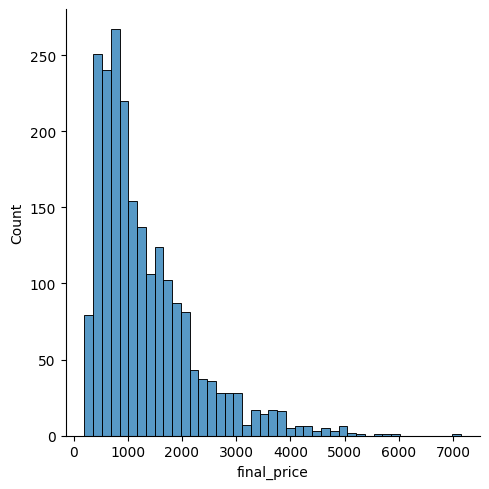

In [ ]:
sns.displot(df["final_price"])

Question 1

There's one column with missing values. What is it?

In [8]:
null_columns = 0
for column in df.columns:
    if pd.isna(df[column]).any():
        print(column)


screen


Question 2

What's the median (50% percentile) for variable 'ram'?

In [ ]:
df["ram"].median()

np.float64(16.0)

In [10]:
n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

In [11]:
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [ ]:
print("Split sizes:", len(df_train), len(df_val), len(df_test))

Split sizes: 1296 432 432


Question 3

In [ ]:
missing_mean = df_train["screen"].mean()
# df_train["screen"].fillna(missing_mean)
df_train["screen"].fillna(0)

0       15.6
1       14.1
2       14.0
3       13.3
4       16.0
        ... 
1291    14.0
1292    16.0
1293    15.6
1294    14.0
1295    14.0
Name: screen, Length: 1296, dtype: float64

In [ ]:
df_train.head()

,ram,storage,screen,final_price
0,32,1000,15.6,1123.29
1,4,64,14.1,201.05
2,32,1000,14.0,997.74
3,16,512,13.3,1016.00
4,32,1000,16.0,2739.00


In [ ]:
df_train.head()

,ram,storage,screen,final_price
0,32,1000,15.6,1123.29
1,4,64,14.1,201.05
2,32,1000,14.0,997.74
3,16,512,13.3,1016.00
4,32,1000,16.0,2739.00


In [16]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [17]:
y_train_orig = df_train.final_price.values
y_val_orig = df_val.final_price.values
y_test_orig = df_test.final_price.values

y_train = np.log1p(y_train_orig)
y_val = np.log1p(y_val_orig)
y_test = np.log1p(y_test_orig)

In [ ]:
y_train

array([7.024907  , 5.30851519, 6.90649448, ..., 6.96602419, 7.42177579,
       6.96318999])

In [19]:
del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

In [20]:
check = ["ram", "storage", "screen"]

def prepare_X(df, fillna_value):
    df_num = df[check]
    df_num = df_num.fillna(fillna_value)
    X = df_num.values
    return X

In [21]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [22]:
mean = df_train.screen.mean()

X_mean_train = prepare_X(df_train, fillna_value=mean)
w_0_mean, w_mean = train_linear_regression(X_mean_train, y_train)

In [23]:
X_mean_val = prepare_X(df_val, fillna_value=mean)
y_mean_pred_val = w_0_mean + X_mean_val.dot(w_mean)

In [ ]:
np.round(rmse(y_val, y_mean_pred_val),2)

np.float64(0.43)

Question 4

In [25]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [26]:
X_null_train = prepare_X(df_train, fillna_value=0)
X_null_val = prepare_X(df_val, fillna_value=0)

In [ ]:
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    w_0, w = train_linear_regression_reg(X_null_train, y_train, r=r)
    y_null_reg_val = w_0 + X_null_val.dot(w)
    rmse_val = np.round(rmse(y_val, y_null_reg_val),2)
    print(r, w_0, rmse_val)

0 6.7271637061124565 0.43
0.01 6.721004333260311 0.43
0.1 6.666075503828241 0.43
1 6.162616499461121 0.43
5 4.616086176497502 0.46
10 3.5167547207936254 0.51
100 0.6849263362660534 0.67


Question 5

In [28]:
rmse_store = np.array()
for s in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:

    n = len(df)

    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.seed(s)
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train_orig = df_train.final_price.values
    y_val_orig = df_val.final_price.values
    y_test_orig = df_test.final_price.values

    y_train = np.log1p(y_train_orig)
    y_val = np.log1p(y_val_orig)
    y_test = np.log1p(y_test_orig)

    X_null_train = prepare_X(df_train, fillna_value=0)
    X_null_val = prepare_X(df_val, fillna_value=0)

    w_0, w = train_linear_regression(X_null_train, y_train)
    y_null_reg_val = w_0 + X_null_val.dot(w)
    rmse_val = np.round(rmse(y_val, y_null_reg_val),3)
    rmse_store.append(rmse_val)

TypeError: array() missing required argument 'object' (pos 0)

In [34]:
np.array(rmse_store)

array([0.43 , 0.452, 0.446, 0.446, 0.42 , 0.425, 0.449, 0.431, 0.443,
       0.408])

In [36]:
round(np.std(np.array(rmse_store)), 3)

np.float64(0.014)

In [ ]:
# n = len(df)

# n_val = int(0.2 * n)
# n_test = int(0.2 * n)
# n_train = n - (n_val + n_test)

# idx = np.arange(n)
# np.random.seed(s)
# np.random.shuffle(idx)

# df_shuffled = df.iloc[idx]

# df_train = df_shuffled.iloc[:n_train].copy()
# df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
# df_test = df_shuffled.iloc[n_train+n_val:].copy()

# df_train = df_train.reset_index(drop=True)
# df_val = df_val.reset_index(drop=True)
# df_test = df_test.reset_index(drop=True)

# y_train_orig = df_train.final_price.values
# y_val_orig = df_val.final_price.values
# y_test_orig = df_test.final_price.values
# df_train.

# y_train = np.log1p(y_train_orig)
# y_val = np.log1p(y_val_orig)
# y_test = np.log1p(y_test_orig)

# X_null_train = prepare_X(df_train, fillna_value=0)
# X_null_val = prepare_X(df_val, fillna_value=0)

# w_0, w = train_linear_regression_reg(X_null_train, y_train, 0.001)
# y_null_reg_val = w_0 + X_null_val.dot(w)
# rmse_val = np.round(rmse(y_val, y_null_reg_val),3)
# rmse_store.append(rmse_val)